In [225]:
import numpy as np
import pickle
import healpy as hp
import matplotlib.pyplot as plt
import os
import subprocess
import sys
sys.path.append('../shared')
sys.path.append('../nilc_pipeline')
from input import Info
from generate_maps import generate_freq_maps
from load_weight_maps import load_wt_maps
from utils import setup_output_dir, tsz_spectral_response, GaussianNeedlets, build_NILC_maps

In [226]:
font = {'size'   : 20, 'family':'STIXGeneral'}
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

### To run this notebook, first run nilc_pipeline/main.py and template_fitting_pipeline/main.py with save_files=1 in the yaml files. The variable save_dir below should be the directory in which to save the plots (set save_dir=None if you don't want to save the plots).

In [227]:
save_dir = 'pipeline_plots'

sim = 0
if not os.path.isdir(save_dir):
    env = os.environ.copy()
    subprocess.call(f'mkdir {save_dir}', shell=True, env=env)


## Read input yaml file

In [228]:
# main input file containing most specifications 
input_file = '/Users/kristen/Documents/GitHub/NILC-Inference-Pipeline/nilc_pipeline/laptop.yaml'

# read in the input file and set up relevant info object
inp = Info(input_file)
inp.ell_sum_max = inp.ellmax

KeyError: 'scaling_factor'

## Sample input maps and power spectra

saved pipeline_plots/input_maps.pdf


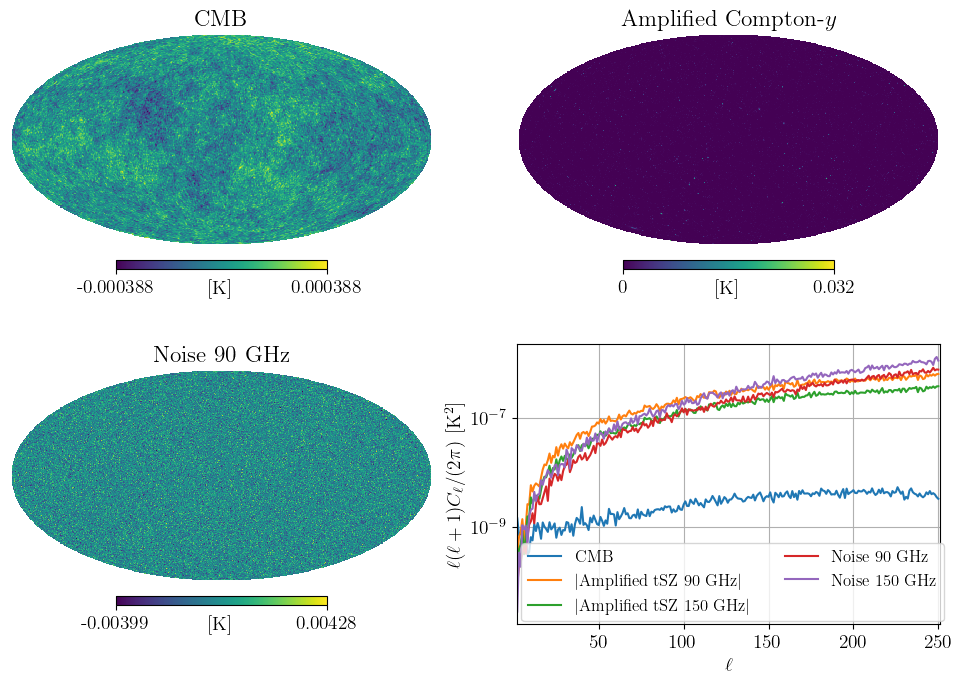

In [229]:
cmb_cl, tsz_cl, noise1_cl, noise2_cl, cmb_map, tsz_map, noise1_map, noise2_map = generate_freq_maps(sim, inp, save=False)
ells_sum = np.arange(inp.ell_sum_max+1)

g_cmb = np.array([1., 1.])
g_tsz = tsz_spectral_response(inp.freqs)

fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()
margins=None #(1,1,1,1)

plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':14})

for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        hp.mollview(cmb_map, fig=1, hold=True, title='CMB', format='%.03g')
    elif n==1:
        hp.mollview(tsz_map, fig=2, hold=True, title=r'Amplified Compton-$y$', format='%.03g')
    elif n==2:
        hp.mollview(noise1_map, fig=3, hold=True, title='Noise 90 GHz', format='%.03g')
    else:
        to_dl = ells_sum*(ells_sum+1)/2/np.pi
        plt.plot(ells_sum[2:], (to_dl*cmb_cl)[2:], label='CMB')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[0]*tsz_cl)[2:], label=r'$|$Amplified tSZ 90 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[1]*tsz_cl)[2:], label=r'$|$Amplified tSZ 150 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*noise1_cl)[2:], label='Noise 90 GHz', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*noise2_cl)[2:], label='Noise 150 GHz', linestyle='solid')
        plt.xlabel(r'$\ell$', fontsize=14)
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}/(2\pi)$ [$\mathrm{K}^2$]', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid()
        plt.legend(fontsize=12, ncol=2, loc=(0.01,0.01))
        plt.yscale('log')
        plt.xlim(2,inp.ell_sum_max+1)
    if n==0 or n==1 or n==2:
        plt.text(0.47, -0.02, r'$[\mathrm{K}]$', transform=ax.transAxes,size=14)

if save_dir:
    plt.savefig(f'{save_dir}/input_maps.pdf', bbox_inches="tight")
    print(f'saved {save_dir}/input_maps.pdf')


plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})

## Needlet filters

saved pipeline_plots/needlet_filters.pdf


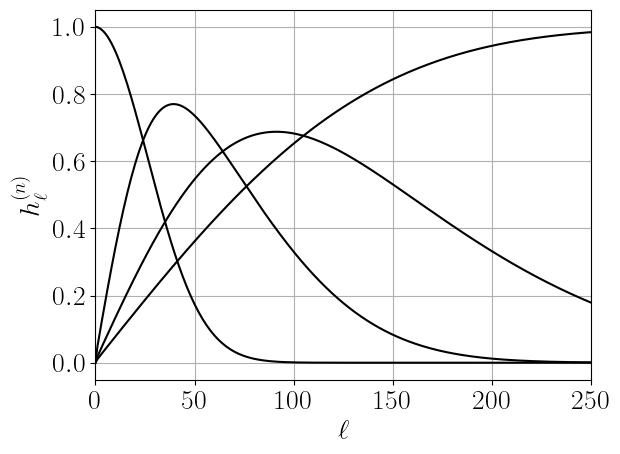

In [230]:
ells_sum, h = GaussianNeedlets(inp)
for n in range(inp.Nscales):
    plt.plot(ells_sum, h[n], color='k')
plt.grid()
plt.xlim(0,inp.ell_sum_max)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$h_\ell^{(n)}$')
if save_dir:
    plt.savefig(f'{save_dir}/needlet_filters.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/needlet_filters.pdf')

## Weight maps for preserved CMB component

In [231]:
CMB_wt_maps, tSZ_wt_maps = load_wt_maps(inp, sim)

saved pipeline_plots/weight_maps_CMB.pdf


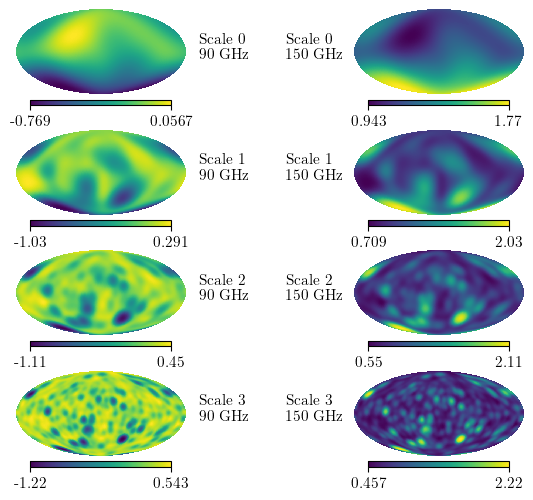

In [232]:
plt.rcParams.update({'font.size':11})

fig, axs = plt.subplots(inp.Nscales, len(inp.freqs), figsize=(8,6))
axs = axs.flatten()

ax = 0
for n in range(inp.Nscales):
    for i in range(len(inp.freqs)):
        plt.axes(axs[ax])
        hp.mollview(CMB_wt_maps[n][i], hold=True, title='', format='%.03g')
        if i == 0:
            plt.text(0.85, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        elif i == 1:
            plt.text(-0.04, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/weight_maps_CMB.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/weight_maps_CMB.pdf')
    
plt.rcParams.update({'font.size':20})

saved pipeline_plots/weight_maps_ftSZ.pdf


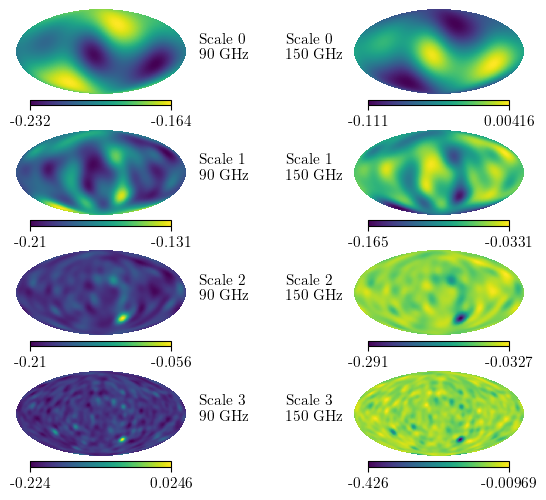

In [233]:
plt.rcParams.update({'font.size':11})

fig, axs = plt.subplots(inp.Nscales, len(inp.freqs), figsize=(8,6))
axs = axs.flatten()

ax = 0
for n in range(inp.Nscales):
    for i in range(len(inp.freqs)):
        plt.axes(axs[ax])
        hp.mollview(tSZ_wt_maps[n][i], hold=True, title='', format='%.03g')
        if i == 0:
            plt.text(0.85, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        elif i == 1:
            plt.text(-0.04, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/weight_maps_ftSZ.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/weight_maps_ftSZ.pdf')
    
plt.rcParams.update({'font.size':20})

## Acmb and Aftsz plots for template-fitting and NILC

saved pipeline_plots/Acmb_Aftsz.pdf


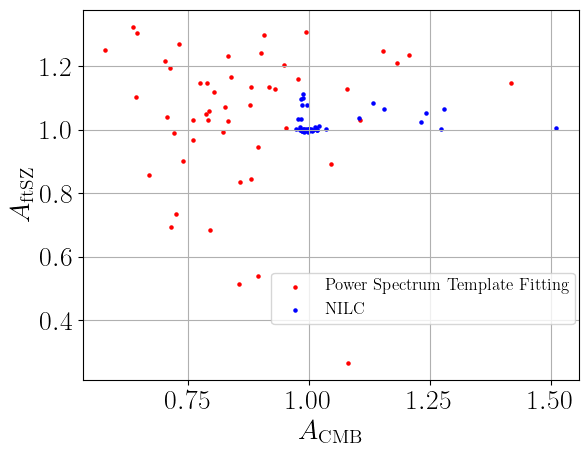

In [234]:
acmb_array_nilc = pickle.load(open(f'{inp.output_dir}/acmb_array_nilc.p', 'rb'))
atsz_array_nilc = pickle.load(open(f'{inp.output_dir}/atsz_array_nilc.p', 'rb'))
acmb_array_template_fitting = pickle.load(open(f'{inp.output_dir}/acmb_array_template_fitting.p', 'rb'))
atsz_array_template_fitting = pickle.load(open(f'{inp.output_dir}/atsz_array_template_fitting.p', 'rb'))

plt.scatter(acmb_array_template_fitting, atsz_array_template_fitting, label='Power Spectrum Template Fitting', s=5, color='red')
plt.scatter(acmb_array_nilc, atsz_array_nilc, label='NILC', s=5, color='blue')
plt.xlabel(r'$A_{\rm CMB}$')
plt.ylabel(r'$A_{\rm ftSZ}$')
plt.legend(fontsize=12, loc=(0.38,0.15))
plt.grid()
if save_dir:
    plt.savefig(f'{save_dir}/Acmb_Aftsz.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/Acmb_Aftsz.pdf')

## Spread of ClTT, ClTy, and Clyy

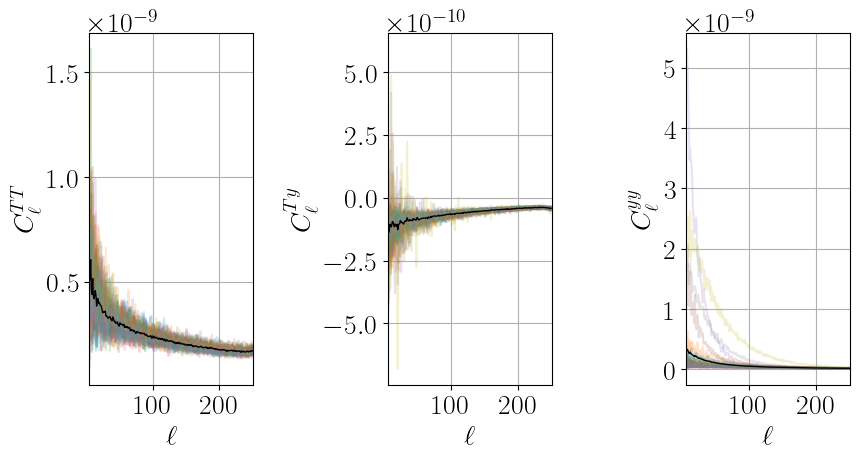

In [235]:
#Clpq has shape (Nsims, N_comps+1, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, ellmax+1)
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))
start = 5
ells = np.arange(inp.ellmax+1)

fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
for p,q in [(0,0), (0,1), (1,1)]:
    plt.axes(axs[ax])
    for sim in range(len(Clpq)):
        plt.plot(ells[start:], np.sum(Clpq[sim,4,p,q,:,:], axis=(0,1))[start:], alpha=0.2)
    plt.plot(ells[start:], np.sum(np.mean(Clpq[:,4,p,q,:,:],axis=0), axis=(0,1))[start:], color='k', linewidth=1.)
    plt.grid()
    plt.xlim(start, inp.ellmax+1)
    plt.xlabel(r'$\ell$')
    if ax==0: plt.ylabel(r'$C_\ell^{TT}$')
    if ax==1: plt.ylabel(r'$C_\ell^{Ty}$')
    if ax==2: plt.ylabel(r'$C_\ell^{yy}$')
    ax += 1
plt.tight_layout()

## How well are ClTT, ClTy, and Clyy reconstructed with parameters for an individual realization?

In [236]:
acmb

array([1.0168033 , 0.98224145, 1.004763  , 0.9845192 , 0.98683554,
       0.9854966 , 1.2789254 , 1.0088899 , 0.985205  , 0.9827807 ,
       0.983503  , 0.98893374, 0.9921572 , 0.9980968 , 0.98641247,
       1.0222033 , 0.9823475 , 1.0160701 , 1.1041808 , 0.98463804,
       1.0060608 , 0.9945723 , 0.998991  , 0.9999412 , 1.0122985 ,
       0.9743669 , 0.98797184, 0.98821855, 0.9787528 , 0.98519945,
       1.2734739 , 1.0154673 , 0.9894543 , 1.0007279 , 1.2432691 ,
       0.99921113, 1.5114995 , 0.99908924, 0.99567264, 0.9883685 ,
       1.1553503 , 0.9913577 , 1.0149947 , 0.98133075, 0.9944811 ,
       0.9933189 , 1.0347689 , 1.232304  , 0.9892143 , 1.1321625 ],
      dtype=float32)

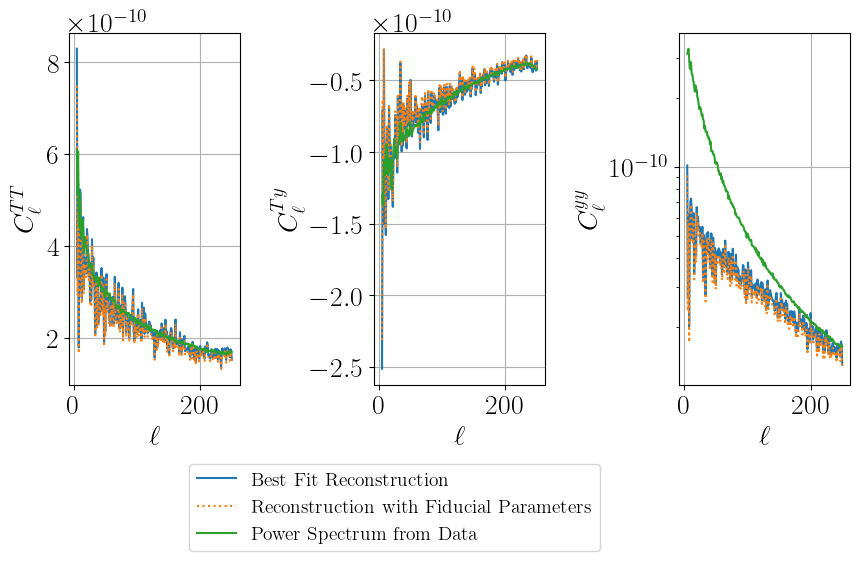

In [237]:
from fits import call_fit

start = 5

#Clpq has shape (Nsims, N_comps+1, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, ellmax+1)
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))

#best_fits has shape (N_preserved_comps, N_preserved_comps, N_comps, N_comps, inp.ellmax+1, 4)
best_fits = pickle.load(open(f'{inp.output_dir}/data_vecs/best_fits.p', 'rb'))

ClTT_data = np.mean(np.sum(Clpq[:,4,0,0], axis=(1,2)), axis=0)
ClTy_data = np.mean(np.sum(Clpq[:,4,0,1], axis=(1,2)), axis=0)
Clyy_data = np.mean(np.sum(Clpq[:,4,1,1], axis=(1,2)), axis=0)

acmb = pickle.load(open(f'{inp.output_dir}/acmb_array_nilc.p', 'rb'))
atsz = pickle.load(open(f'{inp.output_dir}/atsz_array_nilc.p', 'rb'))
anoise1 = pickle.load(open(f'{inp.output_dir}/anoise1_array_nilc.p', 'rb'))
anoise2 = pickle.load(open(f'{inp.output_dir}/anoise2_array_nilc.p', 'rb'))

sim = 6
fig, axs = plt.subplots(1,3, figsize=(9,5))
ax = 0
for p,q in [(0,0), (0,1), (1,1)]:
    plt.axes(axs[ax])
    theory_model = np.zeros(inp.ellmax+1)
    fiducial_model = np.zeros(inp.ellmax+1)
    for y in range(4):
        for z in range(4):
            for ell in range(inp.ellmax+1):
                theory_model[ell] += call_fit([acmb[sim], atsz[sim], anoise1[sim], anoise2[sim]], best_fits[p,q,y,z, ell]) \
                                    * Clpq[sim,4,p,q,y,z,ell]
                fiducial_model[ell] += call_fit([1., 1., 1., 1.], best_fits[p,q,y,z, ell]) \
                                    * Clpq[sim,4,p,q,y,z,ell]
    if ax==0: 
        data_model = ClTT_data
        plt.ylabel(r'$C_\ell^{TT}$')
    elif ax==1: 
        data_model = ClTy_data
        plt.ylabel(r'$C_\ell^{Ty}$')
    else: 
        data_model = Clyy_data
        plt.ylabel(r'$C_\ell^{yy}$')
        plt.yscale('log')
    plt.xlabel(r'$\ell$')
    plt.plot(ells[start:], theory_model[start:], label='Best Fit Reconstruction')
    plt.plot(ells[start:], fiducial_model[start:], label='Reconstruction with Fiducial Parameters', linestyle='dotted')
    plt.plot(ells[start:], data_model[start:], label='Power Spectrum from Data')
    plt.grid()
    ax += 1

handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(0.7, 0.05))
plt.tight_layout()
            

## Make plots of template-fitting analytic covariance (using Gaussian power spectrum covariance)

### Need to run template_fitting/analytic_template_fitting.py after template_fitting/main.py

saved pipeline_plots/analytic_template_fitting.pdf


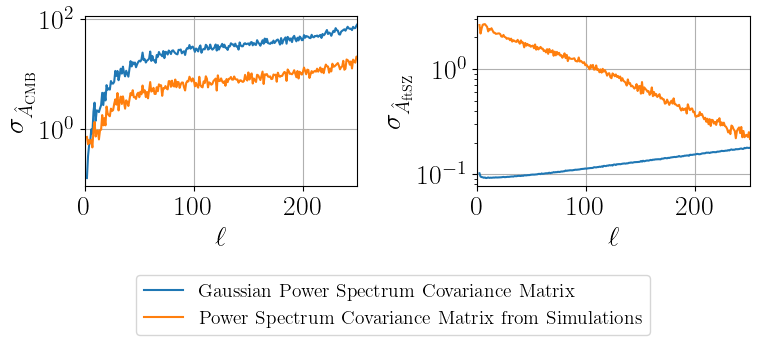

In [238]:
template_fiting_analytic_covar_gaussian = pickle.load(open(f'{inp.output_dir}/template_fiting_analytic_covar_gaussian.p', 'rb'))
template_fiting_analytic_covar_sims = pickle.load(open(f'{inp.output_dir}/template_fiting_analytic_covar_sims.p', 'rb'))
CMB_var_gaussian, CMB_tSZ_covar_gaussian, tSZ_var_gaussian = template_fiting_analytic_covar_gaussian
CMB_var_sims, CMB_tSZ_covar_sims, tSZ_var_sims = template_fiting_analytic_covar_sims
ells = np.arange(inp.ellmax+1)
start = 2

fig, axs = plt.subplots(1,2, figsize=(8,3))
plt.axes(axs[0])
plt.plot(ells[start:], np.sqrt(CMB_var_gaussian)[start:], label='Gaussian Power Spectrum Covariance Matrix')
plt.plot(ells[start:], np.sqrt(CMB_var_sims)[start:], label='Power Spectrum Covariance Matrix from Sims')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{\hat{A}_{\rm CMB}}$')
plt.grid()
plt.xlim(left=0, right=inp.ellmax)
plt.yscale('log')

plt.axes(axs[1])
plt.plot(ells[start:], np.sqrt(tSZ_var_gaussian)[start:], label='Gaussian Power Spectrum Covariance Matrix')
plt.plot(ells[start:], np.sqrt(tSZ_var_sims)[start:], label='Power Spectrum Covariance Matrix from Simulations')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{\hat{A}_{\rm ftSZ}}$')
plt.grid()
plt.xlim(left=0, right=inp.ellmax)
plt.yscale('log')

handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=14, bbox_to_anchor=(0.85, 0.05))
plt.tight_layout()

if save_dir:
    plt.savefig(f'{save_dir}/analytic_template_fitting.pdf', bbox_inches = "tight")
    print(f'saved {save_dir}/analytic_template_fitting.pdf')

# Examine parameter dependence and validate piecewise power law assumption

### To run this section, need to run nilc_pipeline/main.py with output_dir={output_dir1}, scaling_factor={scaling_factor1}, and save_files=1. Then separately run nilc_pipeline/main.py with output_dir={output_dir2}, scaling_factor={scaling_factor2}, and save_files=1, where output_dir1 != output_dir2 and scaling_factor1 != scaling_factor2.

In [165]:
from fits import call_fit

output_dir1 = inp.output_dir
output_dir2 = inp.output_dir + '_0p9'
scaling_factor1 = 1.1
scaling_factor2 = 0.9

#best_fits has shape (N_preserved_comps, N_preserved_comps, N_comps, N_comps, inp.ellmax+1, 4)
best_fits1 = pickle.load(open(f'{output_dir1}/data_vecs/best_fits.p', 'rb'))
best_fits2 = pickle.load(open(f'{output_dir2}/data_vecs/best_fits.p', 'rb'))

saved pipeline_plots/power_law_scaling_ClTT.pdf
saved pipeline_plots/power_law_scaling_ClTy.pdf
saved pipeline_plots/power_law_scaling_Clyy.pdf


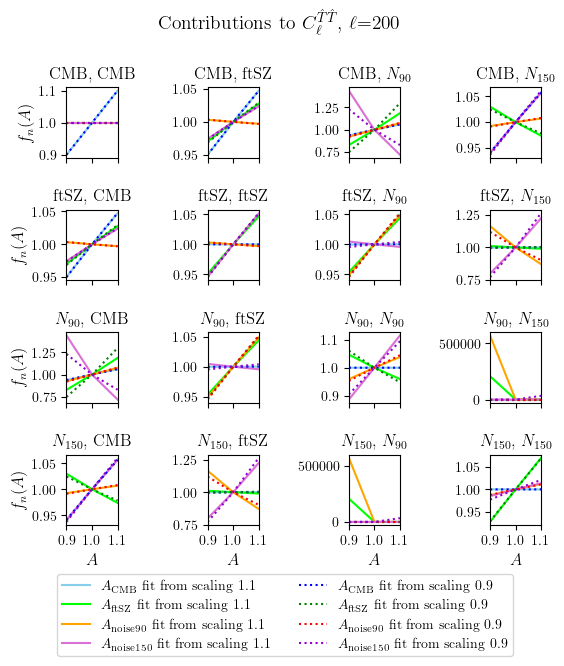

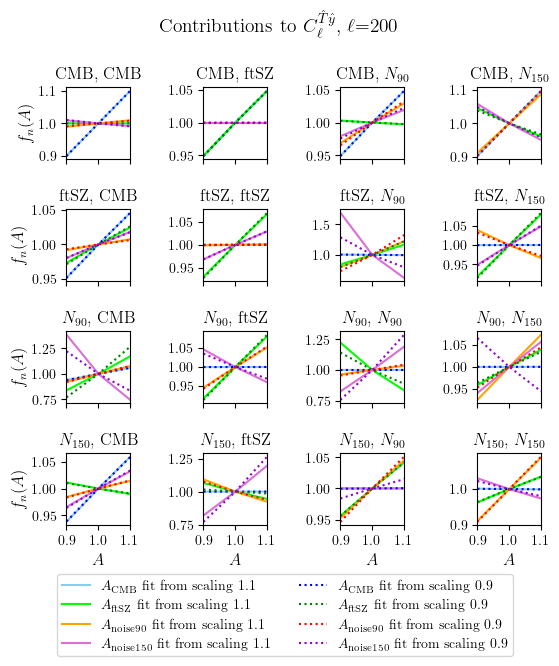

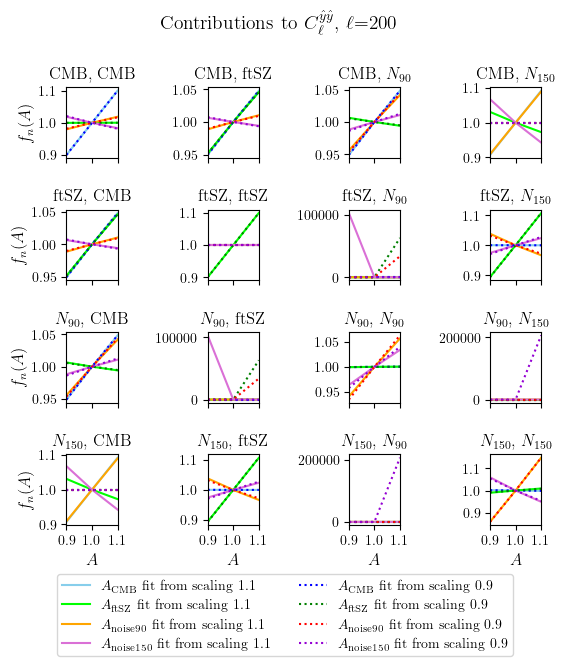

In [178]:
ell = 200
xvals = np.array([0.9, 1.1])
params = np.array([r'$A_{\rm CMB}$', r'$A_{\rm ftSZ}$', r'$A_{\rm noise90}$', r'$A_{\rm noise150}$'])
preserved_comps = ['CMB', 'ftSZ']
comps = ['CMB', 'ftSZ', r'$N_{90}$', r'$N_{150}$']
dark_colors = ['blue', 'green', 'red', 'darkviolet']
light_colors = ['skyblue', 'lime', 'orange', 'orchid']


for p,q in [(0,0), (0,1), (1,1)]:
    fig, axs = plt.subplots(4,4, figsize=(6,6), sharey=False, sharex=True)
    axs = axs.flatten()
    ax = 0
    for y in range(4):
        for z in range(4):
            plt.axes(axs[ax])
            for pass_ in range(2):
                for i in range(4):
                    if pass_==0: plt.plot(xvals, xvals**(best_fits1[p,q,y,z,ell,i]), label=f'{params[i]} fit from scaling 1.1', color=light_colors[i])
                    else: plt.plot(xvals, xvals**(best_fits2[p,q,y,z,ell,i]), label=f'{params[i]} fit from scaling 0.9', linestyle='dotted', color=dark_colors[i])
                plt.grid()
                plt.xlim(0.9, 1.1)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.grid()
                if ax >= 12:
                    plt.xlabel(r'$A$', fontsize=12)
                if ax%4==0:
                    plt.ylabel(r'$f_n(A)$', fontsize=12)
                plt.title(f'{comps[y]}, {comps[z]}', fontsize=12)
            ax += 1
    handles, labels = axs[-1].get_legend_handles_labels() 
    fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.9, 0.05), ncol=2)
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    if (p,q)==(0,0): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{T}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_ClTT.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_ClTT.pdf')
    elif (p,q)==(0,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{y}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_ClTy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_ClTy.pdf')
    elif (p,q)==(1,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{y}\hat{y}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_Clyy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_Clyy.pdf')



saved pipeline_plots/power_law_scaling_ClTT.pdf
saved pipeline_plots/power_law_scaling_ClTy.pdf
saved pipeline_plots/power_law_scaling_Clyy.pdf


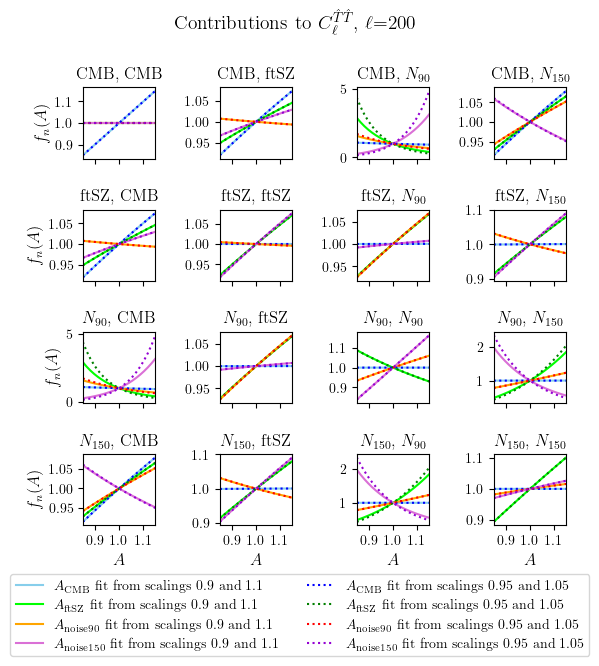

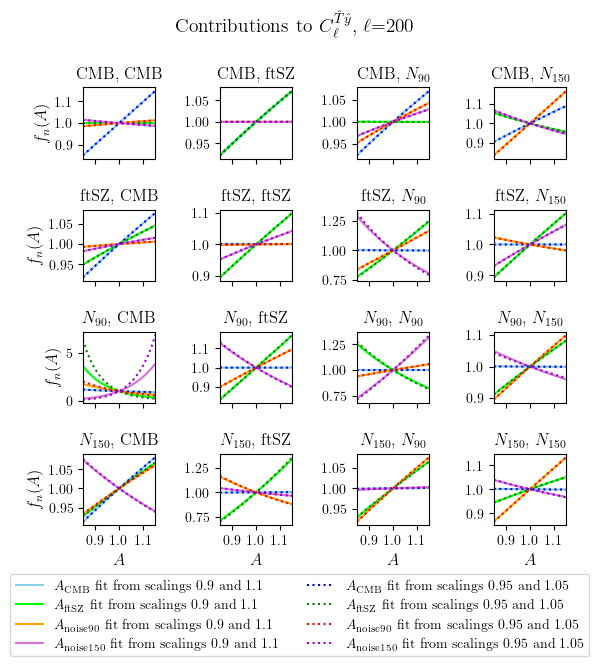

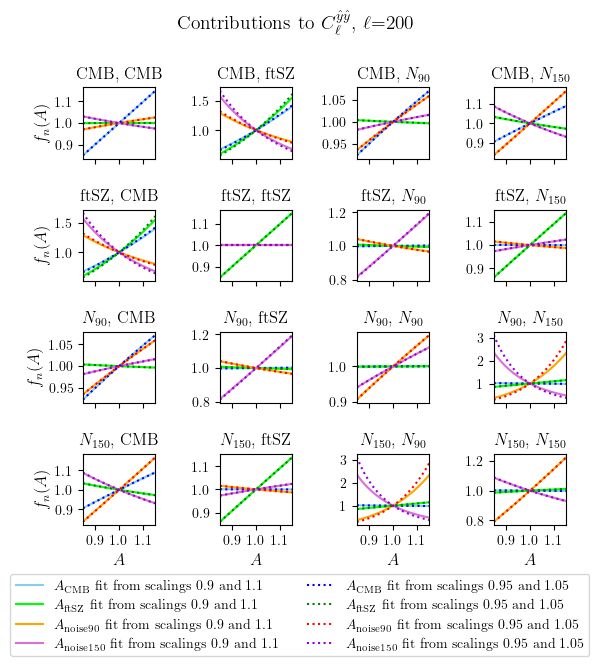

In [289]:
from fits import call_fit

output_dir1 = inp.output_dir
output_dir2 = inp.output_dir + '_1p05'
scaling_factor1 = 1.1
scaling_factor2 = 0.9

#best_fits has shape (N_preserved_comps, N_preserved_comps, N_comps, N_comps, inp.ellmax+1, 4)
best_fits1 = pickle.load(open(f'{output_dir1}/data_vecs/best_fits.p', 'rb'))
best_fits2 = pickle.load(open(f'{output_dir2}/data_vecs/best_fits.p', 'rb'))


ell = 200
xvals = np.linspace(0.85, 1.15, num=20)
params = np.array([r'$A_{\rm CMB}$', r'$A_{\rm ftSZ}$', r'$A_{\rm noise90}$', r'$A_{\rm noise150}$'])
preserved_comps = ['CMB', 'ftSZ']
comps = ['CMB', 'ftSZ', r'$N_{90}$', r'$N_{150}$']
dark_colors = ['blue', 'green', 'red', 'darkviolet']
light_colors = ['skyblue', 'lime', 'orange', 'orchid']


for p,q in [(0,0), (0,1), (1,1)]:
    fig, axs = plt.subplots(4,4, figsize=(6,6), sharey=False, sharex=True)
    axs = axs.flatten()
    ax = 0
    for y in range(4):
        for z in range(4):
            plt.axes(axs[ax])
            for pass_ in range(2):
                for i in range(4):
                    if pass_==0:
                        yvals = xvals**best_fits1[p,q,y,z,ell,i]
                        plt.plot(xvals, yvals, label=f'{params[i]} fit from scalings 0.9 and 1.1', color=light_colors[i])
                    else: 
                        yvals = xvals**best_fits2[p,q,y,z,ell,i]
                        plt.plot(xvals, yvals, label=f'{params[i]} fit from scalings 0.95 and 1.05', linestyle='dotted', color=dark_colors[i])
                plt.grid()
                plt.xlim(min(xvals), max(xvals))
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                #plt.grid(which='both', visible=True)
                if ax >= 12:
                    plt.xlabel(r'$A$', fontsize=12)
                if ax%4==0:
                    plt.ylabel(r'$f_n(A)$', fontsize=12)
                plt.title(f'{comps[y]}, {comps[z]}', fontsize=12)
            ax += 1
    handles, labels = axs[-1].get_legend_handles_labels() 
    fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(1.0, 0.05), ncol=2)
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    if (p,q)==(0,0): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{T}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_ClTT.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_ClTT.pdf')
    elif (p,q)==(0,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{T}\hat{y}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_ClTy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_ClTy.pdf')
    elif (p,q)==(1,1): 
        plt.suptitle('Contributions to ' + r'$C_\ell^{\hat{y}\hat{y}}$, ' + r'$\ell$' + f'={ell}', fontsize=14)
        if save_dir:
            plt.savefig(f'{save_dir}/power_law_scaling_Clyy.pdf', bbox_inches = "tight")
            print(f'saved {save_dir}/power_law_scaling_Clyy.pdf')



## View Relative Contributions of Components to ClTT, ClTy, and Clyy

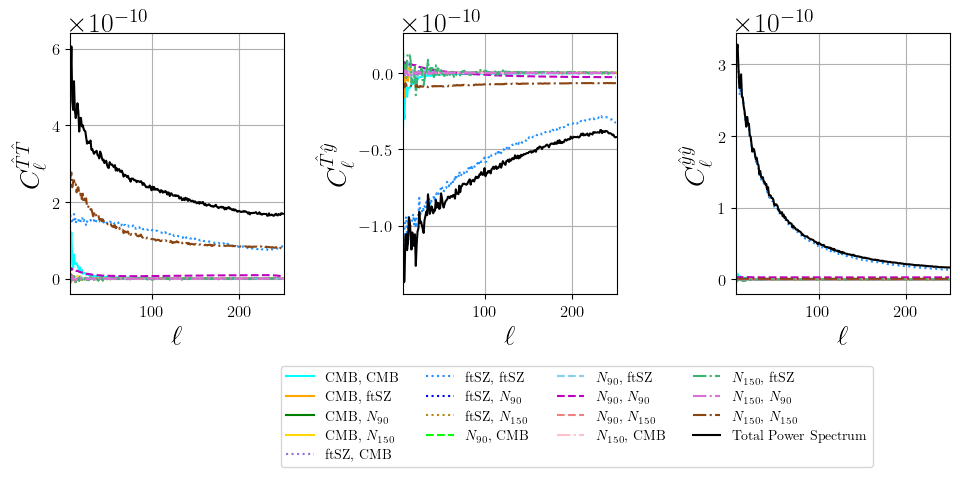

In [241]:
comps = ['CMB', 'ftSZ', r'$N_{90}$', r'$N_{150}$']
start = 5
colors = ['cyan', 'orange', 'green', 'gold', 'mediumpurple', 'dodgerblue', 'blue', 'darkgoldenrod', 'lime', 'skyblue', \
         'm', 'lightcoral', 'pink', 'mediumseagreen', 'orchid', 'saddlebrown']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']

#Clpq has shape (Nsims, N_comps+1=5, N_preserved_comps=2, N_preserved_comps=2, N_comps=4, N_comps=4, ellmax+1)
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/Clpq.p', 'rb'))
Clpq_mean = np.mean(Clpq, axis=0)[4]

fig, axs = plt.subplots(1,3, figsize=(10,4))
axs = axs.flatten()
for ax, (p,q) in enumerate([(0,0), (0,1), (1,1)]):
    plt.axes(axs[ax])
    for y in range(4):
        for z in range(4):
            plt.plot(ells[start:], Clpq_mean[p,q,y,z][start:], label=f'{comps[y]}, {comps[z]}', linestyle=linestyles[y], color=colors[y*4+z])
    plt.plot(ells[start:], np.sum(Clpq_mean[p,q], axis=(0,1))[start:], label=f'Total Power Spectrum', color='k')
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(r'$\ell$')
    plt.xlim(start, inp.ellmax+1)
    if (p,q) == (0,0): 
        plt.ylabel(r'$C_\ell^{\hat{T}\hat{T}}$')
#         plt.yscale('log')
    elif (p,q) == (0,1): 
        plt.ylabel(r'$C_\ell^{\hat{T}\hat{y}}$')
#         plt.yscale('log')
    else: 
        plt.ylabel(r'$C_\ell^{\hat{y}\hat{y}}$')
#         plt.yscale('log')

handles, labels = axs[-1].get_legend_handles_labels() 
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.9, 0.05), ncol=4)
plt.tight_layout()